#### Step 5: Findings

With our best model identified, I can now explore deeper into how it works: the importance of features, the samples it most easily classifies, the samples it's least able to classify, as well as plot a confusion matrix to see where the predictions are landing.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer

In [2]:
data = pd.read_csv('../data/cleaned_posts.csv')

In [3]:
X = data['title']
y = data['subreddit']

The train/test split will be set to be identical to the modeling phase.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1120)

The tokenizer and classifier need to be re-instantiated and fit.

In [5]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [6]:
cvect = CountVectorizer(ngram_range=(1, 2), stop_words='english', min_df=2, tokenizer=LemmaTokenizer())

In [7]:
lr = LogisticRegression(solver='saga', penalty='l1', max_iter=100, C=0.05)

In [8]:
logreg_pipe = Pipeline([
    ('cvect', cvect),
    ('sscaler', StandardScaler(with_mean=False)),
    ('lr', lr)
])

logreg_pipe.fit(X_train, y_train)

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Pipeline(steps=[('cvect',
                 CountVectorizer(min_df=2, ngram_range=(1, 2),
                                 stop_words='english',
                                 tokenizer=<__main__.LemmaTokenizer object at 0x10d050c10>)),
                ('sscaler', StandardScaler(with_mean=False)),
                ('lr',
                 LogisticRegression(C=0.05, penalty='l1', solver='saga'))])

Our training accuracy score:

In [9]:
logreg_pipe.score(X_train, y_train)

0.961794500723589

Our test accuracy score:

In [10]:
logreg_pipe.score(X_test, y_test)

0.9210069444444444

Next I can look at the feature importances by looking at the highest coefficients (those that increase the log probability of being from r/tea the most) and the lowest coefficients (those that increase the log probability of being from r/Coffee the most).

In [11]:
feature_coefs = pd.DataFrame({'coef' : lr.coef_[0]}, index=cvect.get_feature_names())

In [12]:
feature_coefs.sort_values(by='coef', ascending=False).head(10)

,coef
tea,1.074816
teapot,0.259179
matcha,0.232596
tea ?,0.204695
oolong,0.181656
chai,0.120666
leaf,0.119587
green,0.110783
gaiwan,0.098911
set,0.089228


The words appearing aren't surprising--variations of tea, types of tea, etc. The only token of more than one word is "tea ?" indicating that there may be a significant amount of tea-related questions on r/tea.

In [13]:
feature_coefs.sort_values(by='coef', ascending=True).head(10)

,coef
coffee,-0.795527
grinder,-0.344137
espresso,-0.253348
bean,-0.205271
v60,-0.193805
machine,-0.192044
pour,-0.176446
aeropress,-0.151722
moccamaster,-0.139646
moka,-0.131788


Again, the words appearing here aren't surprising--coffee, grinder, bean, etc. What is interesting is the number of brand names that came up in the top 10: v60, aeropress, moccamaster, and moka all being brands. This may indicate that coffee in general has more brand loyalty and word of mouth advertising. 

To look at the samples and how easily the model classified them, from the test set I'll put the titles, the true subreddit, the predicted subreddit, the predicted probabilities of being from r/coffee and r/tea, as well as a column showing the absolute difference between those two probabilities (where a high value indicates an easily predicted sample and a low value indicating a more difficult or ambiguous sample).

In [14]:
preds = pd.DataFrame({
    'title' : X_test, 
    'actual' : y_test, 
    'predicted' : logreg_pipe.predict(X_test),
    'P(coffee)' : [i[0] for i in logreg_pipe.predict_proba(X_test)],
    'P(tea)' : [i[1] for i in logreg_pipe.predict_proba(X_test)]})

preds['diff'] = np.abs(preds['P(coffee)'] - preds['P(tea)'])

In [15]:
pd.set_option('display.max_colwidth', None)
preds.sort_values(by='P(coffee)').head(10)

,title,actual,predicted,P(coffee),P(tea),diff
748,Harney &amp; Sons English Breakfast Tea is so good. A lovely strong black tea with a smooth taste. I received it as a gift from my boss. What tea did you receive as a gift this year?,tea,tea,0.000055,0.999945,0.999889
3103,I just bought a new box for my tea bags and my wife bought me a couple sampler packs from Twinings and Stash Tea. Was very surprised and happy to find this one in the mix. I’m still new to being adventurous with my tea flavors but this one has been a great one.,tea,tea,0.000424,0.999576,0.999153
4048,Iced green tea and green tea ice cream at the Japanese Tea Garden in San Francisco,tea,tea,0.000451,0.999549,0.999098
2691,Every tea lover's dream: 1 kg of tea leaves or 100 bags of tea. Or both in my case!,tea,tea,0.000749,0.999251,0.998503
270,"If I wanted to make my own mango, and peach &amp; ginger teas: how much dried mango/peach&amp;ginger should I add to the black tea base? I want it to be extremely fruit forward",tea,tea,0.001431,0.998569,0.997137
3809,Got myself a new teapot as an early Xmas gift ! Especially to enjoy my tea Advent calendar,tea,tea,0.001447,0.998553,0.997106
3848,Matcha Green Tea vs White Tea,tea,tea,0.001474,0.998526,0.997052
3060,"This sub for me interested in Tea again, so i found my old cast iron Teapot. But the Tea i make in it tastes really metallic. Anyone know how to fix it?",tea,tea,0.001874,0.998126,0.996253
3291,What are some teas that taste similar to rooibos tea?,tea,tea,0.001910,0.998090,0.996181
4183,Coffee vs. Tea || My tea collection || Exotic tea &amp; common tea type,tea,tea,0.001997,0.998003,0.996006


The clearest r/tea titles seem to mostly contain multiple instances of the word 'tea.' 

In [16]:
preds.sort_values(by='P(tea)').head(10)

,title,actual,predicted,P(coffee),P(tea),diff
2988,"can someone explain this? - Aeropress with Fellow Prismo filter small holes were clogged with dried coffee and it would not pour, but when added paper filter on top of prismo filter the coffee would pour....",Coffee,Coffee,0.999982,0.000018,0.999964
3196,This plastic cone filter from my cheap drip coffee machine fits my cheap pour over cup perfectly giving a priceless full-bodied coffee compared to the recommended paper filter.,Coffee,Coffee,0.999888,0.000112,0.999777
4096,"COFFEE CUPS, COFFEE TYPE FOR COFFEE LOVERS. Espresso, Americano, Frappe, Cappuccino, AND Mocha.",Coffee,Coffee,0.999810,0.000190,0.999620
3705,Key to good crema? I recently changed to a breville espresso machine after using an automatic DēLonghi but struggle to get the same rich crema. Using the same beans and the grind is as fine as it goes almost.... Other tips?,Coffee,Coffee,0.999767,0.000233,0.999534
66,I want start making my coffee at home without a coffee maker. What is recommended to go about this process to make a good coffee?,Coffee,Coffee,0.999047,0.000953,0.998093
76,"My mr coffee 5 cup programmable coffee maker is burning my coffee? It taste like dirt, how can I fix it?",Coffee,Coffee,0.998930,0.001070,0.997860
1230,"I have a cheap Mr. Coffee drip maker, is it worth it to buy an expensive coffee grinder?",Coffee,Coffee,0.998887,0.001113,0.997775
1022,Can i use this salt grinder as a coffee grinder? Can't buy one right now. My other option is an old hand grinder.,Coffee,Coffee,0.998767,0.001233,0.997534
3350,Newbie question - Can I use any ground coffee for my espresso machine?,Coffee,Coffee,0.998629,0.001371,0.997259
4129,"Coffee machine help? I recently got a Keurig coffee maker, but it was a gift and I'm unsure of the model; could someone point me to where I can get reusable cups for grinds for this?",Coffee,Coffee,0.998598,0.001402,0.997196


Similarly, the clearest r/Coffee titles seem to contain the word 'coffee' multiple times or several instances of words like 'espresso', 'grinder', or types of coffee. 

In [17]:
preds.sort_values(by='diff').head(10)

,title,actual,predicted,P(coffee),P(tea),diff
2553,What To Eat First,tea,Coffee,0.500569,0.499431,0.001139
3903,Interest in Espresso/Flair products,Coffee,Coffee,0.500569,0.499431,0.001139
4590,Dianhong with bergamot rind,tea,Coffee,0.500569,0.499431,0.001139
2812,GIVE ME COFEE,Coffee,Coffee,0.500569,0.499431,0.001139
2191,Thankful for this subreddit,Coffee,Coffee,0.500569,0.499431,0.001139
3735,My goodness this thing is loud.....,Coffee,Coffee,0.500569,0.499431,0.001139
1194,Malty flavor similar to aftertaste of pilsner,Coffee,Coffee,0.500569,0.499431,0.001139
313,Non-dairy cream substitute,tea,Coffee,0.500569,0.499431,0.001139
927,My pretty strainer didn’t work really well,tea,Coffee,0.500569,0.499431,0.001139
2107,Where can I buy more of this and can I get some more info on it,tea,Coffee,0.500569,0.499431,0.001139


Looking at the lowest difference values is a little bit more revealing. First off, it seems like all of these low difference samples ended up leaning just slightly into r/Coffee on the prediction, with a consistent probability across them. I would imagine that this may be the model defaulting to classifying samples with no important information it recognizes as being in the (slightly) more common class, just like our null model.

We see some titles which just don't have many key words to grab ('What To Eat First', 'Thankful for this subreddit'), but also some that look like they should be easy to classify, but upon closer inspection, have misspellings or formattings that may have made them hard to recognize. 

First we can look at a sample where 'chamomile' is spelled incorrectly, with two Ls. 

In [18]:
sample_2l = ['I have the weirdest feeling that chamomille and pineapple go together really well']
logreg_pipe.predict_proba(sample_2l)

array([[0.50056947, 0.49943053]])

In [19]:
sample_1l = ['I have the weirdest feeling that chamomile and pineapple go together really well']
logreg_pipe.predict_proba(sample_1l)

array([[0.33483933, 0.66516067]])

Correcting the spelling pushes the prediction solidly into r/tea as expected.

Next, it seems like the tokenizer was unable to process the slash between two words, as we've seen that 'espresso' is generally an important feature in classifying a sample as from r/Coffee. 

In [20]:
sample_esp = ['Interest in Espresso/Flair products']
logreg_pipe.predict_proba(sample_esp)

array([[0.50056947, 0.49943053]])

In [21]:
sample_esp = ['Interest in Espresso / Flair products']
logreg_pipe.predict_proba(sample_esp)

array([[0.86661357, 0.13338643]])

As expected, once the model is able to read the two words independently, the prediction moves from essentially a toss-up to very clearly being from r/Coffee. 

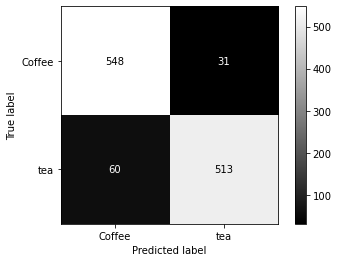

In [22]:
plot_confusion_matrix(logreg_pipe, X_test, y_test, cmap='gist_gray');

Like we saw above, the model is generally classifying more samples incorrectly as being from r/Coffee than as being from r/tea. Considering the size and quality of the data as well as the limitations of the natural language processing techniques, though, I'm fairly pleased with the model's ability to accurately classify. 